# TP2 - DB Normalization and Querying

The objectives of this TP are:
1. Apply normalization 1NF -> 2NF -> 3NF
2. Perform SQL queries on the normalized database

In this TP, we will use a database **`wine.db`** (available in the course's website) containing wine information related to 'production' and 'sales'. 

> Production <---> Wine <---> Sales


---

### Working with db files in Jupyter
- Python provides an interface for SQLite through the *sqlite3* module
- The **`%%sql`** magic builds upon it (and other tools) to enable the usage of SQL commands within a Jupyter Notebook as in common SQL clients.
- Before proceeding, make sure that **`wine.db`** is in the same path as this notebook.
  - If **`wine.db`** is not in the same path, an empty **`wine.db`** file will be created, resulting in errors in later steps of the TP.
- The SQLite module in Python commits transactions automatically, this means that any change in the DB is immediately written to the file, e.g. creating/deleting tables.
  -  For this reason, it is recommended to have a backup of **`wine.db`** as it is provided in the course's website.

---

**`wine.db`** contains the following unnormalized tables:

<center>**Master1**</center>

|*Attribute*|         *Description*          |
| -------   |--------------------------------|
| NV        | Wine number                    |
| CRU       | Vineyard or group of vineyards |
| DEGRE     | Alcohol content                |
| MILL      | Vintage year                   |
| QTE       | Number of bottles harvested    |
| NP        | Producer number                |
| NOM       | Producer's last name           |
| PRENOM    | Producer's first name          |
| REGION    | Production region              |

From wikipedia:

__Cru__: Often used to indicate a specifically named and legally defined vineyard or ensemble of vineyards and the vines "which grow on [such] a reputed terroir; by extension of good quality." The term is also used to refer to the wine produced from such vines.


<center>**Master2**</center>

|*Attribute*|                         *Description*                  |
| -------   |--------------------------------------------------------|
| NV        | Wine number                                            |
| CRU       | Vineyard or group of vineyards                         |
| DEGRE     | Alcohol content                                        |
| MILL      | Vintage year                                           |
| DATES     | Buying date                                            |
| LIEU      | Place where the wine was sold                          |
| QTE       | Number of bottles bought                               |
| NB        | Client (buveur) number                                 |
| NOM       | Client's last name                                     |
| PRENOM    | Client's first name                                    |
| TYPE      | Type of client by volume of purchases                  |
| REGION    | Administrative Region (different to production region) |


In [1]:
import sqlite3    # Python interface for SQLite databases

In [2]:
def printSchema(connection):
    # Function to print the DB schema
    # Source: http://stackoverflow.com/a/35092773/4765776
    for (tableName,) in connection.execute(
        """
        select NAME from SQLITE_MASTER where TYPE='table' order by NAME;
        """
    ):
        print("{}:".format(tableName))
        for (
            columnID, columnName, columnType,
            columnNotNull, columnDefault, columnPK,
        ) in connection.execute("pragma table_info('{}');".format(tableName)):
            print("  {id}: {name}({type}){null}{default}{pk}".format(
                id=columnID,
                name=columnName,
                type=columnType,
                null=" not null" if columnNotNull else "",
                default=" [{}]".format(columnDefault) if columnDefault else "",
                pk=" *{}".format(columnPK) if columnPK else "",
            ))

In [3]:
conn = sqlite3.connect('wine.db')
c = conn.cursor()
print("Database schema:")
printSchema(conn)           # An usefull way to viualize the content of the database

Database schema:
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)


From this point we will use __%%sql__ magic

In [4]:
%load_ext sql
%sql sqlite:///wine.db

'Connected: @wine.db'

# PART I: Database normalization

The first task on this TP is the normalization of the wine data. In its current state both tables **Master1** and **Master2** are in the First Normal Form (1NF).

By inspecting the content of these tables we can see that multiple tuples have NULL values.

In [5]:
%sql select * from MASTER1 LIMIT 10;

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
None,None,None,None,None,3,Six,Paul,Alsace
None,None,None,None,None,6,Marmagne,Bernard,Bourgogne
None,None,None,None,None,8,Lioger d'Harduy,Gabriel,Bourgogne
None,None,None,None,None,16,Barbin,Bernard,Bourgogne
None,None,None,None,None,17,Faiveley,Guy,Bourgogne
None,None,None,None,None,18,Tramier,Jean,Bourgogne
None,None,None,None,None,19,Dupaquier,Roger,Bourgogne
None,None,None,None,None,20,Lamy,Jean,Bourgogne
None,None,None,None,None,21,Cornu,Edmond,Bourgogne
None,None,None,None,None,26,Violot,Gilbert,Bourgogne


* Notice that Jupyter *displays* 'None' instead of 'NULL'. 
  - This is only to comply with python notation.
* To account for NULL values, your SQL queries must test explicitly for 'NULL'.

Another problem in **Master1** and **Master2** is data redundancy, for example:

In [6]:
%%sql SELECT *
FROM Master1
WHERE NV = 45;

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL,QTE,NP,NOM,PRENOM,REGION
45,Chiroubles,None,1983,90,2,Boxler,Albert,Alsace
45,Chiroubles,None,1983,912,67,Descombes,Jean Ernest,Beaujolais
45,Chiroubles,None,1983,98,71,Chalandard,Danile,Jura
45,Chiroubles,None,1983,540,78,Michlel,Pierre Emile,Jura
45,Chiroubles,None,1983,450,86,Dumazet,Marc,Rhone


---

Additional resource for Normalization:

https://www.youtube.com/watch?v=UrYLYV7WSHM

---

#### Exercise 1.1

Convert table **Master1** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.
  
Remember that **`wine.db`** contains information related to wine 'production' and 'sells'.

> Production <---> Wine <---> Sales

A good start point is to look for the 'Wine' attributes.

**Hint:** Look for redundant information between the master tables.

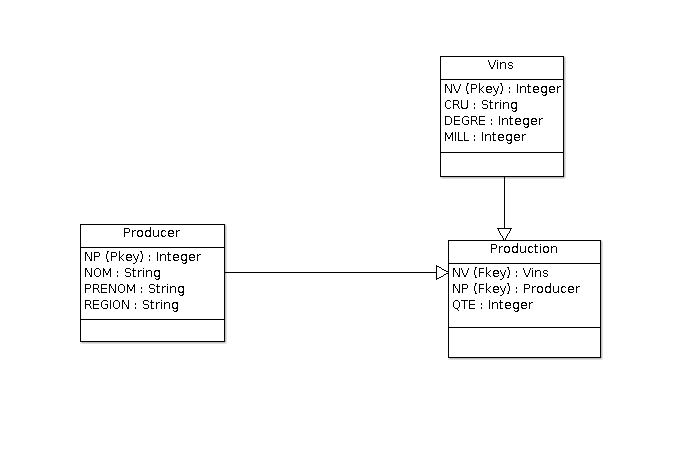

#### Exercise 1.2

Convert table **Master2** to the Second Normal Form (2NF) or Third Normal Form (3NF) as applicable.
* Explain your answer
* List main functional dependencies (not all of them)
* Describe the schema of new tables and how they relate
  * You can write Tables as above or you can insert images in the notebook.

**Note:** For this part, consider that a wine can be bought in multiple locations and multiple times per day.

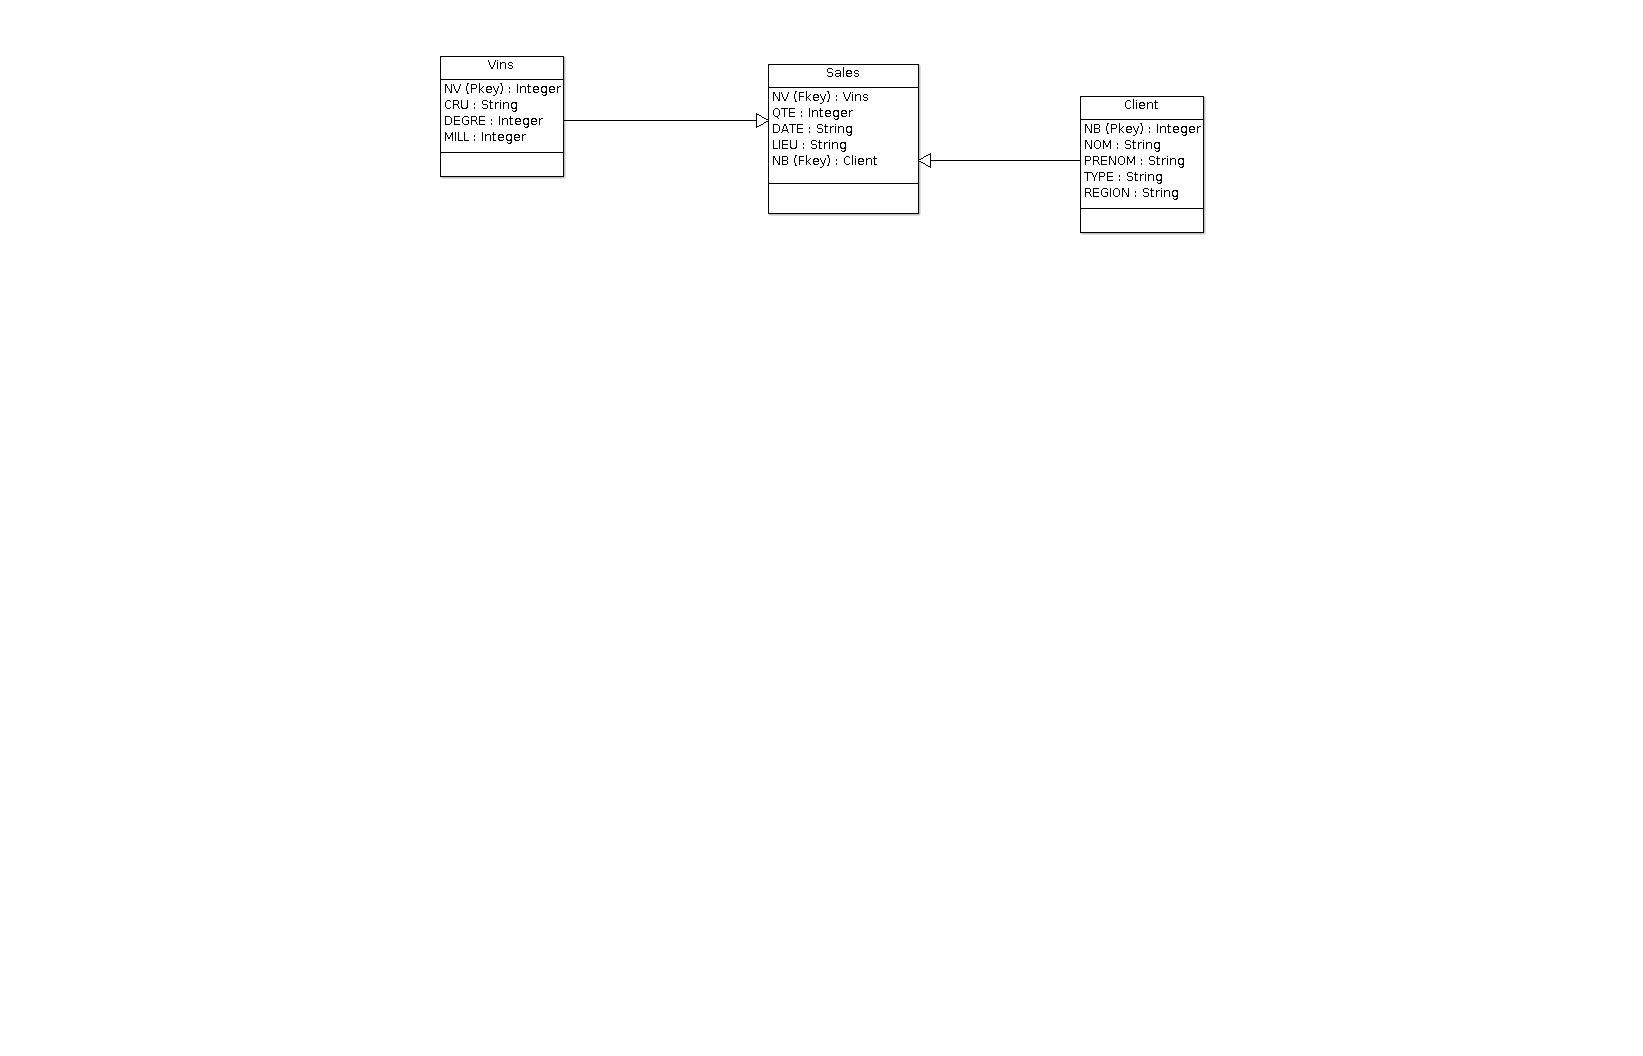

Once you have defined the 2NF or 3NF (as applicable) we need to split the data into new tables.

A table can be created from the result of a query.

In the following example we will create a new table "dummy" to store the different values of alcohol content.

In [7]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1;

 * sqlite:///wine.db
Done.
Done.


[]

In [8]:
print("\nContent of the database")
printSchema(conn)


Content of the database
MASTER1:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: QTE(NUM)
  5: NP(NUM)
  6: NOM(TEXT)
  7: PRENOM(TEXT)
  8: REGION(TEXT)
MASTER2:
  0: NV(NUM)
  1: CRU(TEXT)
  2: DEGRE(NUM)
  3: MILL(NUM)
  4: DATES(DATE)
  5: LIEU(TEXT)
  6: QTE(NUM)
  7: NB(NUM)
  8: NOM(TEXT)
  9: PRENOM(TEXT)
  10: TYPE(TEXT)
  11: REGION(TEXT)
dummy:
  0: DEGRE(NUM)


In [9]:
%%sql
SELECT *
FROM dummy;

 * sqlite:///wine.db
Done.


DEGRE
None
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8


Looking into "dummy", we notice that our query includes NULL. This is not allowed if we were to use DEGRE as key for a table.

To correct this, we need to change the query to explicitly test for NULL as follows:

In [10]:
%%sql DROP TABLE IF EXISTS dummy;

-- Create dummy table
CREATE TABLE dummy AS
SELECT DISTINCT DEGRE
FROM MASTER1
WHERE DEGRE IS NOT NULL;

SELECT *
FROM dummy;

 * sqlite:///wine.db
Done.
Done.
Done.


DEGRE
11.5
11.3
12.1
10.9
11.7
11.2
12.3
11.9
11.8
10.7


Notice that we use `NULL` given that `None` is only used for display.

In [11]:
# Remove "dummy" table
%sql DROP TABLE IF EXISTS dummy;

 * sqlite:///wine.db
Done.


[]

#### Exercise 1.3

Create the new tables from Master1:

In [21]:
%%sql DROP TABLE IF EXISTS Vins;
DROP TABLE IF EXISTS Producer;
DROP TABLE IF EXISTS Production;

-- Create Vins table
CREATE TABLE Vins AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER1
WHERE NV IS NOT NULL;

-- Create Producer table
CREATE TABLE Producer AS
SELECT DISTINCT NP, NOM, PRENOM, REGION
FROM MASTER1
WHERE NP IS NOT NULL;

-- Create Production table
CREATE TABLE Production AS
SELECT NP, NV, QTE
FROM MASTER1;

SELECT *
FROM Vins Limit 10;

SELECT *
FROM Producer Limit 10;

SELECT *
FROM Production
WHERE NV IS NOT NULL Limit 10;

 * sqlite:///wine.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


NP,NV,QTE
1,1,300
73,1,1
5,2,100
1,3,400
10,4,35
30,5,46
42,6,300
98,7,60
90,8,12
None,9,None


#### Exercise 1.4

Create the new tables from Master2:

In [26]:
%%sql DROP TABLE IF EXISTS Vins;
DROP TABLE IF EXISTS Client;
DROP TABLE IF EXISTS Sales;

-- Create Vins table
CREATE TABLE Vins AS
SELECT DISTINCT NV, CRU, DEGRE, MILL
FROM MASTER2
WHERE NV IS NOT NULL;

-- Create Client table
CREATE TABLE Client AS
SELECT DISTINCT NB, NOM, PRENOM, TYPE, REGION
FROM MASTER2
WHERE NB IS NOT NULL;

-- Create Sales table
CREATE TABLE Sales AS
SELECT NB, NV, QTE, DATES, LIEU
FROM MASTER2;

SELECT *
FROM Vins Limit 10;

SELECT *
FROM Client Limit 10;

SELECT *
FROM Sales
WHERE NV IS NOT NULL Limit 10;

 * sqlite:///wine.db
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


NB,NV,QTE,DATES,LIEU
2,1,33,1977-11-02,BORDEAUX
44,1,1,2015-10-16,PARIS
45,1,1,1983-12-31,RENNES
48,2,2,1983-12-25,LYON
7,3,6,1978-11-01,NICE
49,3,5,1987-12-24,MERCUREY
8,4,12,1982-11-05,TOULOUSE
44,4,6,2015-10-16,PARIS
50,4,4,1981-06-29,SENS
2,5,50,1984-11-04,MERCUREY


# PART II: SQL QUERIES

In the second part of this TP you will create SQL queries to retrieve information from the database.

**Important:**

- You MUST use the normalized tables created in previous steps.
  - The normalized tables will also be used in TP3.
- Do NOT use **Master1** and **Master2** in your queries.

#### Exercise 2.1

What are the different types of clients (buveurs) by volume of purchases?

In [29]:
%%sql
SELECT DISTINCT NB, QTE
FROM Sales
GROUP BY QTE;

 * sqlite:///wine.db
Done.


NB,QTE
11,None
44,1
48,2
44,3
50,4
49,5
7,6
58,7
60,8
61,9


#### Exercise 2.2

What regions produce Pommard or Brouilly?

In [52]:
%%sql
SELECT DISTINCT Producer.REGION
FROM Vins, Production, Producer
WHERE Vins.NV = Production.NV
AND Production.NP = Producer.NP
AND (Vins.CRU LIKE 'Pommard' OR Vins.CRU LIKE 'Brouilly')

 * sqlite:///wine.db
Done.


REGION
Bourgogne
Rhone


#### Exercise 2.3

What regions produce Pommard and Brouilly?

In [53]:
%%sql
SELECT Producer.REGION
FROM Vins, Production, Producer
WHERE Vins.NV = Production.NV
AND Production.NP = Producer.NP
AND Vins.CRU LIKE 'Pommard' 
AND Producer.REGION IN (SELECT Producer.REGION
FROM Vins, Production, Producer
WHERE Vins.NV = Production.NV
AND Production.NP = Producer.NP
AND Vins.CRU LIKE 'Brouilly')

 * sqlite:///wine.db
Done.


REGION
Bourgogne


#### Exercise 2.4

Get the number of wines bught by CRU and Millésime

In [62]:
%%sql SELECT sum(QTE), NV
FROM Sales
GROUP BY NV;

 * sqlite:///wine.db
Done.


sum(QTE),NV
None,None
35,1
2,2
11,3
22,4
55,5
36,6
31,7
96,8
30,9


#### Exercise 2.5

Retrieve the wine number (NV) of wines produced by more than three producers

In [72]:
%%sql SELECT count(Producer.NP) as compte, NV
FROM Producer, Production
WHERE Producer.NP = production.NP
AND NV IS NOT NULL
GROUP BY NV
Having compte > 3;

 * sqlite:///wine.db
Done.


compte,NV
5,45
5,78
4,89
5,98


#### Exercise 2.6

Which producers have not produced any wine?

In [86]:
%%sql 
SELECT NP, NOM, PRENOM
FROM Producer
WHERE Producer.NP NOT IN (SELECT NP
FROM Production
WHERE Production.NV IS NOT NULL
AND Production.NP IS NOT NULL
ORDER BY NP);

 * sqlite:///wine.db
Done.


NP,NOM,PRENOM
3,Six,Paul
6,Marmagne,Bernard
8,Lioger d'Harduy,Gabriel
16,Barbin,Bernard
17,Faiveley,Guy
18,Tramier,Jean
19,Dupaquier,Roger
20,Lamy,Jean
21,Cornu,Edmond
26,Violot,Gilbert


#### Exercise 2.7

What clients (buveurs) have bought at least one wine from 1980?

In [94]:
%%sql SELECT DISTINCT Client.NB, Client.NOM, Client.PRENOM
FROM client, Sales, Vins
WHERE Client.NB = Sales.NB
AND Sales.NV = Vins.NV
AND Vins.MILL = 1980
AND (Sales.QTE = 1 or Sales.QTE > 1)

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM
2,Artaud,Antonin
44,Gide,Andre
45,Giono,Jean
8,Aragon,Louis
50,Lautreamont,None
61,Mallarme,Stephane


#### Exercise 2.8

What clients (buveurs) have NOT bought any wine from 1980?

In [97]:
%%sql SELECT DISTINCT Client.NB
FROM client
WHERE Client.NB NOT IN (SELECT DISTINCT Client.NB
FROM client, Sales, Vins
WHERE Client.NB = Sales.NB
AND Sales.NV = Vins.NV
AND Vins.MILL = 1980
AND (Sales.QTE = 1 or Sales.QTE > 1));

 * sqlite:///wine.db
Done.


NB
11
13
16
18
20
21
23
25
27
29


#### Exercise 2.9

What clients (buveurs) have bought ONLY wines from 1980?

In [102]:
%%sql SELECT DISTINCT Client.NB
FROM client
WHERE Client.NB IN (SELECT DISTINCT Client.NB
FROM Client, Sales, Vins
WHERE Client.NB = Sales.NB
AND Sales.NV = Vins.NV
AND Vins.MILL = 1980
AND (Sales.QTE = 1 or Sales.QTE > 1))
AND Client.NB NOT IN (SELECT DISTINCT Client.NB
FROM client, Sales, Vins
WHERE Client.NB = Sales.NB
AND Sales.NV = Vins.NV
AND Vins.MILL != 1980)

 * sqlite:///wine.db
Done.


NB
44
45
50


#### Exercise 2.10

List all wines from 1980

In [116]:
%%sql SELECT *
FROM Vins
WHERE MILL = 1980

 * sqlite:///wine.db
Done.


NV,CRU,DEGRE,MILL
1,Mercurey,11.5,1980
4,Mercurey,10.9,1980
16,Meursault,12.1,1980
20,Cote de Brouilly,12.1,1980
26,Chateau Corton Grancey,None,1980
28,Volnay,11,1980
43,Fleurie,11.4,1980
74,Arbois,12,1980
78,Etoile,12,1980
79,Seyssel,11,1980


#### Exercise 2.11

What are the wines from 1980 bought by NB=2?

In [108]:
%%sql SELECT DISTINCT Vins.NV, Vins.CRU, Vins.MILL
FROM Client, Sales, Vins
WHERE Client.NB = 2
AND Client.NB = Sales.NB
AND Sales.NV = Vins.NV
AND Vins.MILL = 1980

 * sqlite:///wine.db
Done.


NV,CRU,MILL
1,Mercurey,1980


#### Exercise 2.12

What clients (buveurs) have bought ALL the wines from 1980?

In [120]:
%%sql SELECT Client.NB, Client.NOM, Client.PRENOM, count(Vins.NV) as compte
FROM Client, Sales, Vins
WHERE Client.NB = Sales.NB
AND Sales.NV = Vins.NV
AND Vins.MILL = 1980
GROUP BY Client.NB
HAVING compte = (SELECT count(NV)
FROM Vins
WHERE MILL = 1980)

 * sqlite:///wine.db
Done.


NB,NOM,PRENOM,compte
44,Gide,Andre,18
